In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [ ]:
# -----Imports------
# For data handling and preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split

# For time series and sequence manipulation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import breaks_cusumolsresid

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization,Conv1D
from tensorflow.keras.callbacks import EarlyStopping

# For model evaluation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# For handling Data Loading
import zipfile
import urllib.request

import optuna

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/'
os.chdir(data_path)

print("Available files:")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available files:
 best_model.h5
'Damage Propagation Modeling.pdf'
 forecast_comparison_unit_-0.0014_FD001.png
 forecast_comparison_unit_0.001_FD004.png
 forecast_comparison_unit_10.0037_FD004.png
 forecast_comparison_unit_20.0078_FD004.png
 forecast_comparison_unit_34.9994_FD004.png
 forecast_comparison_unit_35.0075_FD004.png
 readme.txt
 rul_distribution_unit20.0072.png
 RUL_FD001.txt
 RUL_FD002.txt
 RUL_FD003.txt
 RUL_FD004.txt
 RUL_forecasts_FD001.png
 RUL_forecasts_FD004.png
 RUL_predictions_FD001.csv
 RUL_predictions_FD004.csv
 rul_predictions_unit20.0072.png
 rul_predictions_unit24.9984_FD004.png
 rul_predictions_unit42.0_FD004.png
 rul_summary_unit20.0072.csv
 rul_uncertainty_unit20.0072.png
 test_FD001.txt
 test_FD002.txt
 test_FD003.txt
 test_FD004.txt
 train_FD001.txt
 train_FD002.txt
 train_FD003.txt
 train_FD004.txt
 training_history.png


In [ ]:
def load_cmapss_data(dataset_id):
    cols = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]

    train_path = f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/train_FD00{dataset_id}.txt'
    train_df = pd.read_csv(train_path, sep=' ', header=None, names=cols)
    train_df = train_df.drop(columns=['op3'])
    train_df = train_df.dropna(axis=1)

    test_path = f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/test_FD00{dataset_id}.txt'
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=cols)
    test_df = test_df.drop(columns=['op3'])
    test_df = test_df.dropna(axis=1)

    rul_path = f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/RUL_FD00{dataset_id}.txt'
    rul_df = pd.read_csv(rul_path, sep=' ', header=None, names=['RUL'])
    rul_df = rul_df.dropna(axis=1)

    max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
    max_cycles.columns = ['unit', 'max_cycle']

    train_df = train_df.merge(max_cycles, on='unit', how='left')
    train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
    train_df = train_df.drop(columns=['max_cycle'])

    return train_df, test_df, rul_df

def select_features(train_df):
    correlation = train_df.corr()['RUL'].sort_values(ascending=False)
    sensors = [col for col in correlation.index if 'sensor' in col and abs(correlation[col]) > 0.3]
    return ['op1', 'op2'] + sensors

def prepare_sequences(df, sequence_length, sensors, target_col='RUL'):
    X = []
    y = []
    units = []
    cycles = []

    for unit in df['unit'].unique():
        unit_data = df[df['unit'] == unit]
        features = unit_data[sensors].values
        target = unit_data[target_col].values

        for i in range(len(unit_data) - sequence_length):
            X.append(features[i:i+sequence_length])
            y.append(target[i+sequence_length])
            units.append(unit)
            cycles.append(unit_data['cycle'].values[i+sequence_length])

    return np.array(X), np.array(y), np.array(units), np.array(cycles)


In [ ]:
def objective(trial):
    global quantile_weights

    # Hyperparameter suggestions
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256)
    lstm_units_2 = trial.suggest_int("lstm_units_2", 64, 256)
    lstm_units_3 = trial.suggest_int("lstm_units_3", 64, 256)
    use_lstm_3 = trial.suggest_categorical("use_lstm_3", [True, False])
    use_bidirectional = trial.suggest_categorical("use_bidirectional", [True, False])
    rnn_type = trial.suggest_categorical("rnn_type", ["LSTM", "GRU"])
    lstm_activation = trial.suggest_categorical("lstm_activation", ["tanh", "relu"])
    dense_activation = trial.suggest_categorical("dense_activation", ["relu", "selu", "swish"])
    attention_activation = trial.suggest_categorical("attention_activation", ["relu", "swish"])
    use_norm = trial.suggest_categorical("use_norm", ["layer", None])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.5)
    dropout_rate_1 = trial.suggest_float("dropout_rate_1", 0.0, 0.5)
    dropout_rate_2 = trial.suggest_float("dropout_rate_2", 0.0, 0.5)
    dropout_rate_3 = trial.suggest_float("dropout_rate_3", 0.0, 0.5)
    dense_dropout_rate = trial.suggest_float("dense_dropout_rate", 0.0, 0.5)
    dense_units_1 = trial.suggest_int("dense_units_1", 32, 256)
    dense_units_2 = trial.suggest_int("dense_units_2", 32, 256)
    shared_dense_units = trial.suggest_int("shared_dense_units", 16, 64)
    final_branch_dense_units = trial.suggest_int("final_branch_dense_units", 16, 64)
    attention_units = trial.suggest_int("attention_units", 16, 128)
    multi_head_attention = trial.suggest_categorical("multi_head_attention", [True, False])
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    residual_connections = trial.suggest_categorical("residual_connections", [True, False])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "nadam"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 5e-3)
    clipnorm = trial.suggest_float("clipnorm", 1.0, 5.0)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-3)
    sequence_length = trial.suggest_int("sequence_length", 30, 60)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    epochs = trial.suggest_int("epochs", 20, 50)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 5, 15)
    use_lr_schedule = trial.suggest_categorical("use_lr_schedule", [True, False])
    lr_patience = trial.suggest_int("lr_patience", 2, 5)
    lr_reduction_factor = trial.suggest_float("lr_reduction_factor", 0.5, 0.9)
    swa_start_epoch = trial.suggest_int("swa_start_epoch", 5, 20)
    smooth_factor = trial.suggest_float("smooth_factor", 0.01, 0.1)
    quantile_weights = {
        0.1: trial.suggest_float("q10_weight", 1.0, 2.0),
        0.5: trial.suggest_float("q50_weight", 1.0, 2.0),
        0.9: trial.suggest_float("q90_weight", 1.0, 2.0),
    }

    # Load & preprocess data
    train_df, test_df, rul_df = load_cmapss_data(dataset_id=1)
    selected_sensors = select_features(train_df)

    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    train_df[selected_sensors] = scaler_features.fit_transform(train_df[selected_sensors])
    train_df['RUL'] = scaler_target.fit_transform(train_df[['RUL']])
    test_df[selected_sensors] = scaler_features.transform(test_df[selected_sensors])
    if 'RUL' in test_df.columns:
        test_df['RUL'] = scaler_target.transform(test_df[['RUL']])

    X, y, _, _ = prepare_sequences(train_df, sequence_length, selected_sensors)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build model
    def apply_rnn(layer, x):
        return Bidirectional(layer)(x) if use_bidirectional else layer(x)

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    rnn1 = LSTM(lstm_units_1, activation=lstm_activation, return_sequences=True, recurrent_dropout=recurrent_dropout) if rnn_type == 'LSTM' else GRU(lstm_units_1, activation=lstm_activation, return_sequences=True, recurrent_dropout=recurrent_dropout)
    x = apply_rnn(rnn1, inputs)
    if use_norm == 'layer': x = LayerNormalization()(x)
    x = Dropout(dropout_rate_1)(x)

    rnn2 = LSTM(lstm_units_2, activation=lstm_activation, return_sequences=True, recurrent_dropout=recurrent_dropout) if rnn_type == 'LSTM' else GRU(lstm_units_2, activation=lstm_activation, return_sequences=True, recurrent_dropout=recurrent_dropout)
    x2 = apply_rnn(rnn2, x)
    if residual_connections and x.shape[-1] == x2.shape[-1]: x2 = Add()([x, x2])
    if use_norm == 'layer': x2 = LayerNormalization()(x2)
    x2 = Dropout(dropout_rate_2)(x2)

    # Attention
    attention_outputs = []
    for _ in range(num_attention_heads):
        attn = Dense(attention_units, activation=attention_activation)(x2)
        attn = Dense(1, activation='tanh')(attn)
        weights = Lambda(lambda t: tf.nn.softmax(t, axis=1))(attn)
        context = Multiply()([weights, x2])
        context = Lambda(lambda t: tf.reduce_sum(t, axis=1))(context)
        attention_outputs.append(context)

    context_vector = Concatenate()(attention_outputs) if multi_head_attention else attention_outputs[0]

    if use_lstm_3:
        rnn3 = LSTM(lstm_units_3, activation=lstm_activation, recurrent_dropout=recurrent_dropout) if rnn_type == 'LSTM' else GRU(lstm_units_3, activation=lstm_activation, recurrent_dropout=recurrent_dropout)
        x3 = apply_rnn(rnn3, Reshape((1, -1))(context_vector))
        if use_norm == 'layer': x3 = LayerNormalization()(x3)
        x3 = Dropout(dropout_rate_3)(x3)
    else:
        x3 = context_vector

    x4 = Dense(dense_units_1, activation=dense_activation)(x3)
    x4 = Dropout(dense_dropout_rate)(x4)
    x5 = Dense(dense_units_2, activation=dense_activation)(x4)
    shared = Dense(shared_dense_units, activation=dense_activation)(x5)

    # Quantile outputs
    outputs = []
    for q in quantiles:
        q_out = Dense(final_branch_dense_units, activation=dense_activation)(shared)
        q_out = Dense(1, name=f'q{int(q*100)}')(q_out)
        outputs.append(q_out)

    model = Model(inputs=inputs, outputs=outputs)

    # Loss
    def quantile_loss(q):
        def loss(y_true, y_pred):
            e = y_true - y_pred
            smooth = smooth_factor
            return tf.reduce_mean(tf.maximum(q * e * (1 - smooth), (q - 1) * e * (1 - smooth))) * quantile_weights[q]
        return loss

    losses = {f'q{int(q*100)}': quantile_loss(q) for q in quantiles}

    # Choose either a learning rate schedule or a fixed learning rate with ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, verbose=0),
        SWA(swa_start_epoch, swa_freq=2)
    ]

    if use_lr_schedule:
        # Option 1: Use a learning rate schedule
        lr = CosineDecayRestarts(learning_rate, 15, t_mul=2.0, m_mul=0.85)
    else:
        # Option 2: Use a fixed learning rate with ReduceLROnPlateau
        lr = learning_rate
        callbacks.append(
            ReduceLROnPlateau(factor=lr_reduction_factor, patience=lr_patience, min_lr=1e-6, verbose=0)
        )

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm, weight_decay=weight_decay)
    else:  # nadam
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr, clipnorm=clipnorm, weight_decay=weight_decay)

    model.compile(optimizer=optimizer, loss=losses)

    y_train_dict = {f'q{int(q*100)}': y_train for q in quantiles}
    y_val_dict = {f'q{int(q*100)}': y_val for q in quantiles}

    model.fit(X_train, y_train_dict,
              validation_data=(X_val, y_val_dict),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=callbacks,
              verbose=1)

    # Evaluate
    val_preds = model.predict(X_val, verbose=0)
    val_q50 = val_preds[1]
    mae = np.mean(np.abs(scaler_target.inverse_transform(y_val.reshape(-1, 1)) -
                         scaler_target.inverse_transform(val_q50.reshape(-1, 1))))

    print(f"Trial MAE: {mae:.4f}")
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

print("Best hyperparameters:")
print(study.best_params)


[I 2025-05-21 08:56:27,056] A new study created in memory with name: no-name-3f5fd9ff-50ca-422f-a56b-669b82131b6e


Epoch 1/39
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 0.3751 - q10_loss: 0.0748 - q50_loss: 0.2043 - q90_loss: 0.0960 - val_loss: 0.2745 - val_q10_loss: 0.0630 - val_q50_loss: 0.1679 - val_q90_loss: 0.0435
Epoch 2/39
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.2767 - q10_loss: 0.0630 - q50_loss: 0.1706 - q90_loss: 0.0432 - val_loss: 0.2697 - val_q10_loss: 0.0616 - val_q50_loss: 0.1668 - val_q90_loss: 0.0412
Epoch 3/39
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.2743 - q10_loss: 0.0623 - q50_loss: 0.1699 - q90_loss: 0.0421 - val_loss: 0.2692 - val_q10_loss: 0.0611 - val_q50_loss: 0.1665 - val_q90_loss: 0.0415
Epoch 4/39
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.2740 - q10_loss: 0.0628 - q50_loss: 0.1692 - q90_loss: 0.0420 - val_loss: 0.2696 - val_q10_loss: 0.0621 - val_q50_loss: 0.1662 - val_q90_loss: 0.0412
Epoch 5/39
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.2743 - q10_loss: 0.0630 - q50_loss: 0.1696 - q90_loss: 0.0416 - val_loss: 0.2705 - val_q1

[I 2025-05-21 09:00:38,905] Trial 0 finished with value: 0.00025120064901609405 and parameters: {'lstm_units_1': 164, 'lstm_units_2': 155, 'lstm_units_3': 252, 'use_lstm_3': True, 'use_bidirectional': True, 'rnn_type': 'LSTM', 'lstm_activation': 'relu', 'dense_activation': 'selu', 'attention_activation': 'relu', 'use_norm': 'layer', 'recurrent_dropout': 0.0019793507441079328, 'dropout_rate_1': 0.3640362521975794, 'dropout_rate_2': 0.12838123177027239, 'dropout_rate_3': 0.20513657233299798, 'dense_dropout_rate': 0.254112451211155, 'dense_units_1': 180, 'dense_units_2': 234, 'shared_dense_units': 52, 'final_branch_dense_units': 55, 'attention_units': 118, 'multi_head_attention': False, 'num_attention_heads': 2, 'residual_connections': True, 'optimizer': 'adam', 'learning_rate': 0.002402643756926705, 'clipnorm': 1.3743056695575913, 'weight_decay': 0.0008055918329009168, 'sequence_length': 51, 'batch_size': 256, 'epochs': 39, 'early_stopping_patience': 12, 'use_lr_schedule': True, 'lr_pati

Trial MAE: 0.0003
Epoch 1/21
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 363ms/step - loss: 0.4110 - q10_loss: 0.0623 - q50_loss: 0.2265 - q90_loss: 0.1222 - val_loss: 0.2784 - val_q10_loss: 0.0563 - val_q50_loss: 0.1658 - val_q90_loss: 0.0579 - learning_rate: 0.0036
Epoch 2/21
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 321ms/step - loss: 0.2850 - q10_loss: 0.0573 - q50_loss: 0.1684 - q90_loss: 0.0592 - val_loss: 0.2869 - val_q10_loss: 0.0583 - val_q50_loss: 0.1654 - val_q90_loss: 0.0655 - learning_rate: 0.0036
Epoch 3/21
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - loss: 0.2825 - q10_loss: 0.0572 - q50_loss: 0.1663 - q90_loss: 0.0590 - val_loss: 0.2811 - val_q10_loss: 0.0566 - val_q50_loss: 0.1654 - val_q90_loss: 0.0611 - learning_rate: 0.0036
Epoch 4/21
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 0.2822 - q10_loss: 0.0572 - q50_loss: 0.1667 - q90_loss: 0.0583 - val_loss: 0.2780 - val_q10_loss: 0.0565 - val_q50_loss: 0.1654 - val_q90_loss: 0.0579 - learning_rate: 0.0036
Epoch 5/21
49/49 ━━━━━━━━━━━━━━━━━

[I 2025-05-21 09:04:16,879] Trial 1 finished with value: 0.0002518489034606916 and parameters: {'lstm_units_1': 194, 'lstm_units_2': 174, 'lstm_units_3': 118, 'use_lstm_3': True, 'use_bidirectional': False, 'rnn_type': 'LSTM', 'lstm_activation': 'tanh', 'dense_activation': 'selu', 'attention_activation': 'swish', 'use_norm': None, 'recurrent_dropout': 0.22394023002247138, 'dropout_rate_1': 0.3773993289865304, 'dropout_rate_2': 0.4115197523324365, 'dropout_rate_3': 0.09638269900526242, 'dense_dropout_rate': 0.21442399643552124, 'dense_units_1': 244, 'dense_units_2': 38, 'shared_dense_units': 19, 'final_branch_dense_units': 64, 'attention_units': 19, 'multi_head_attention': True, 'num_attention_heads': 3, 'residual_connections': False, 'optimizer': 'nadam', 'learning_rate': 0.0035933913136315045, 'clipnorm': 1.954188934212974, 'weight_decay': 0.00023047210805534203, 'sequence_length': 48, 'batch_size': 256, 'epochs': 21, 'early_stopping_patience': 5, 'use_lr_schedule': False, 'lr_patienc

Trial MAE: 0.0003
Best hyperparameters:
{'lstm_units_1': 164, 'lstm_units_2': 155, 'lstm_units_3': 252, 'use_lstm_3': True, 'use_bidirectional': True, 'rnn_type': 'LSTM', 'lstm_activation': 'relu', 'dense_activation': 'selu', 'attention_activation': 'relu', 'use_norm': 'layer', 'recurrent_dropout': 0.0019793507441079328, 'dropout_rate_1': 0.3640362521975794, 'dropout_rate_2': 0.12838123177027239, 'dropout_rate_3': 0.20513657233299798, 'dense_dropout_rate': 0.254112451211155, 'dense_units_1': 180, 'dense_units_2': 234, 'shared_dense_units': 52, 'final_branch_dense_units': 55, 'attention_units': 118, 'multi_head_attention': False, 'num_attention_heads': 2, 'residual_connections': True, 'optimizer': 'adam', 'learning_rate': 0.002402643756926705, 'clipnorm': 1.3743056695575913, 'weight_decay': 0.0008055918329009168, 'sequence_length': 51, 'batch_size': 256, 'epochs': 39, 'early_stopping_patience': 12, 'use_lr_schedule': True, 'lr_patience': 3, 'lr_reduction_factor': 0.6426300594950889, 'sw

In [ ]:
print("Best hyperparameters:")
print(study.best_params)

# Extract best hyperparameters
best_params = study.best_params

# Prepare data again (full train data)
train_df, test_df, rul_df = load_cmapss_data(dataset_id=1)
selected_sensors = select_features(train_df)

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_df[selected_sensors] = scaler_features.fit_transform(train_df[selected_sensors])
train_df['RUL'] = scaler_target.fit_transform(train_df[['RUL']])

test_df[selected_sensors] = scaler_features.transform(test_df[selected_sensors])

# Prepare full sequences
X, y, units, cycles = prepare_sequences(train_df, best_params['sequence_length'], selected_sensors)

# Build final model with best hyperparameters
inputs = Input(shape=(X.shape[1], X.shape[2]))

x = LSTM(best_params['lstm_units_1'], activation='relu', return_sequences=True)(inputs)
x = Dropout(best_params['dropout_rate_1'])(x)

x = LSTM(best_params['lstm_units_2'], activation='relu', return_sequences=True)(x)
x = Dropout(best_params['dropout_rate_2'])(x)

x = LSTM(best_params['lstm_units_3'], activation='relu')(x)
x = Dropout(best_params['dropout_rate_3'])(x)

x = Dense(best_params['dense_units_1'], activation='relu')(x)
x = Dropout(best_params['dense_dropout_rate'])(x)

x = Dense(best_params['dense_units_2'], activation='relu')(x)
shared_dense = Dense(best_params['shared_dense_units'], activation='relu')(x)

quantiles = [0.1, 0.5, 0.9]
outputs = []
for q in quantiles:
    output = Dense(8, activation='relu')(shared_dense)
    output = Dense(1, name=f'q{int(q*100)}')(output)
    outputs.append(output)

# Final model
model = Model(inputs=inputs, outputs=outputs)

# Quantile loss definition
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))

losses = {f'q{int(q*100)}': (lambda q: (lambda y_true, y_pred: quantile_loss(q, y_true, y_pred)))(q) for q in quantiles}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss=losses)

# Train final model on all training data
y_train_dict = {f'q{int(q*100)}': y for q in quantiles}

early_stopping = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X, y_train_dict,
    epochs=50,
    batch_size=best_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# 'model' now contains the final best model.


Best hyperparameters:
{'lstm_units_1': 164, 'lstm_units_2': 155, 'lstm_units_3': 252, 'use_lstm_3': True, 'use_bidirectional': True, 'rnn_type': 'LSTM', 'lstm_activation': 'relu', 'dense_activation': 'selu', 'attention_activation': 'relu', 'use_norm': 'layer', 'recurrent_dropout': 0.0019793507441079328, 'dropout_rate_1': 0.3640362521975794, 'dropout_rate_2': 0.12838123177027239, 'dropout_rate_3': 0.20513657233299798, 'dense_dropout_rate': 0.254112451211155, 'dense_units_1': 180, 'dense_units_2': 234, 'shared_dense_units': 52, 'final_branch_dense_units': 55, 'attention_units': 118, 'multi_head_attention': False, 'num_attention_heads': 2, 'residual_connections': True, 'optimizer': 'adam', 'learning_rate': 0.002402643756926705, 'clipnorm': 1.3743056695575913, 'weight_decay': 0.0008055918329009168, 'sequence_length': 51, 'batch_size': 256, 'epochs': 39, 'early_stopping_patience': 12, 'use_lr_schedule': True, 'lr_patience': 3, 'lr_reduction_factor': 0.6426300594950889, 'swa_start_epoch': 11

In [ ]:
def forecast_rul_intervals(model, input_data, quantiles=[0.1, 0.5, 0.9]):
    predictions = model.predict(input_data)

    if not isinstance(predictions, list):
        predictions = [predictions]

    result = {}
    for i, q in enumerate(quantiles):
        q_str = f'q{int(q*100)}'
        result[q_str] = predictions[i]

    return result

def forecast_multiple_steps_with_intervals(model, initial_sequence, n_steps, sensors, scaler_features, scaler_target, quantiles=[0.1, 0.5, 0.9]):
    sequence = initial_sequence.copy()

    forecasts = {f'q{int(q*100)}': [] for q in quantiles}

    for _ in range(n_steps):
        # Reshape for prediction
        input_seq = sequence.reshape(1, sequence.shape[0], sequence.shape[1])

        # Make prediction
        preds = model.predict(input_seq, verbose=0)

        if not isinstance(preds, list):
            preds = [preds]

        # Store predictions
        for i, q in enumerate(quantiles):
            q_str = f'q{int(q*100)}'
            forecasts[q_str].append(preds[i][0][0])

        # Update sequence for next prediction (using median prediction)
        median_idx = quantiles.index(0.5)
        new_rul = preds[median_idx][0][0]

        # For simplicity, we'll assume all sensors slightly degrade
        # In a real application, you might have a more sophisticated model for sensor evolution
        new_row = sequence[-1].copy()
        for i in range(len(sensors)):
            # Simple degradation trend
            trend = sequence[-1, i] - sequence[-2, i]
            new_row[i] = sequence[-1, i] + trend + np.random.normal(0, 0.01)

        # Remove the first row and add the new row
        sequence = np.vstack([sequence[1:], new_row])

    # Convert to numpy arrays
    for q in quantiles:
        q_str = f'q{int(q*100)}'
        forecasts[q_str] = np.array(forecasts[q_str]).reshape(-1, 1)
        # Inverse transform
        forecasts[q_str] = scaler_target.inverse_transform(forecasts[q_str])

    return forecasts

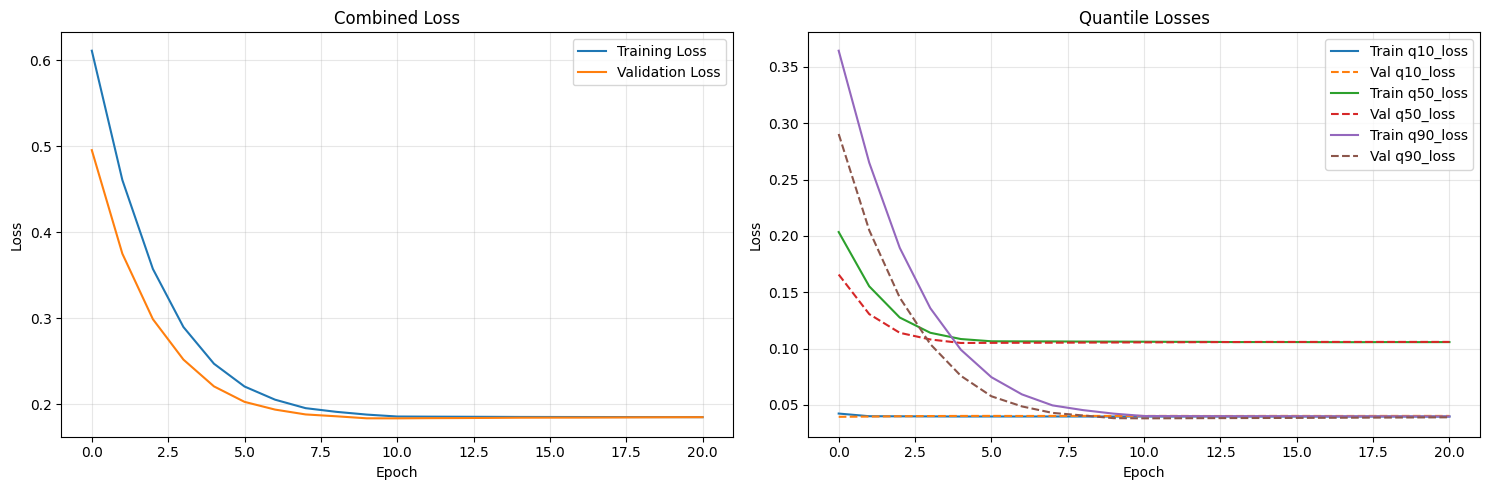

In [ ]:
def visualize_training_history(model):
    """
    Visualize the training history of the model.
    """
    history = model.history.history

    # Plot training and validation loss
    plt.figure(figsize=(15, 5))

    # Plot combined loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Combined Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot individual quantile losses
    plt.subplot(1, 2, 2)

    # Get quantile loss keys
    quantile_keys = [key for key in history.keys() if key.startswith('q') and not key.startswith('val_')]

    for key in quantile_keys:
        plt.plot(history[key], label=f'Train {key}')
        plt.plot(history[f'val_{key}'], label=f'Val {key}', linestyle='--')

    plt.title('Quantile Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_training_history(model)

Loading data...
Adding RUL to test data...
Selecting features...
Selected 13 features: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']
Scaling data...
Preparing sequences...
Building model...
Training model...
Epoch 1/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1866 - quantile_10_loss: 0.0350 - quantile_50_loss: 0.0985 - quantile_90_loss: 0.0531 - val_loss: 0.1517 - val_quantile_10_loss: 0.0268 - val_quantile_50_loss: 0.0837 - val_quantile_90_loss: 0.0420
Epoch 2/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1628 - quantile_10_loss: 0.0303 - quantile_50_loss: 0.0892 - quantile_90_loss: 0.0432 - val_loss: 0.1520 - val_quantile_10_loss: 0.0273 - val_quantile_50_loss: 0.0842 - val_quantile_90_loss: 0.0415
Epoch 3/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1625 - quantile_10_loss: 0.0300 - quantile_50_loss: 0.0901 - quantile_90_loss: 0.0424 - val_loss: 0.1513 - val_quantile_10_loss: 0.0267 - val_quantile_50_loss: 0.0840 - v

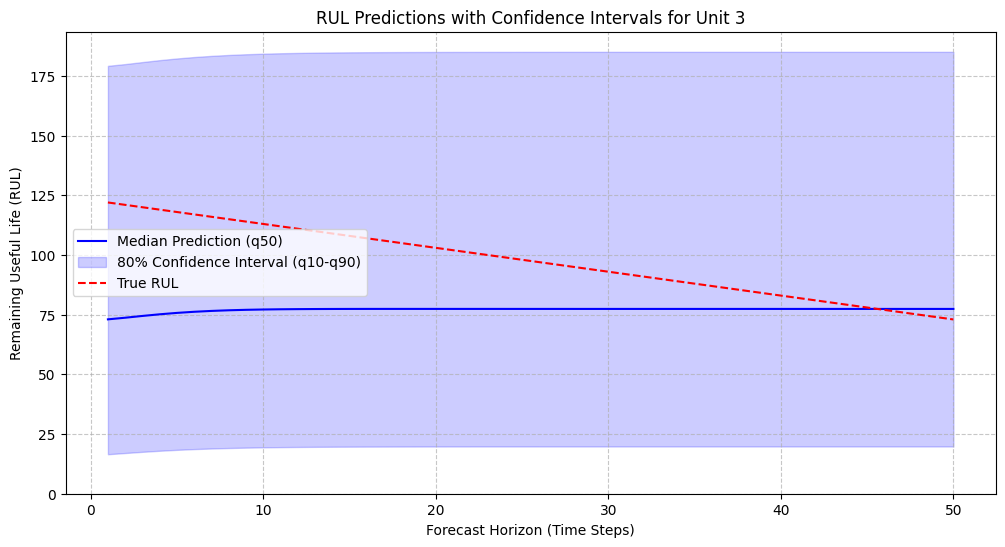

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

def load_cmapss_data(dataset_id):
    """
    Load the CMAPSS dataset.

    Args:
        dataset_id: Dataset ID (1-4)

    Returns:
        train_df: Training data DataFrame
        test_df: Test data DataFrame
        rul_df: RUL values for test data
    """
    # This is a placeholder - implement actual data loading logic for your environment
    # For now, creating dummy data to demonstrate the workflow

    # Create dummy training data
    train_units = 100
    max_cycles = 300
    n_sensors = 21

    train_data = []
    for unit in range(1, train_units + 1):
        max_cycle = np.random.randint(100, max_cycles)
        for cycle in range(1, max_cycle + 1):
            rul = max_cycle - cycle
            row = [unit, cycle, rul] + [np.random.normal(0, 1) for _ in range(n_sensors)]
            train_data.append(row)

    # Column names
    cols = ['unit', 'cycle', 'RUL'] + [f's{i+1}' for i in range(n_sensors)]
    train_df = pd.DataFrame(train_data, columns=cols)

    # Create dummy test data
    test_units = 50
    test_data = []
    true_rul = []

    for unit in range(1, test_units + 1):
        max_cycle = np.random.randint(100, max_cycles)
        test_cycles = np.random.randint(30, max_cycle)
        true_rul.append([unit, max_cycle - test_cycles])

        for cycle in range(1, test_cycles + 1):
            row = [unit, cycle] + [np.random.normal(0, 1) for _ in range(n_sensors)]
            test_data.append(row)

    # Column names for test (no RUL in test data)
    test_cols = ['unit', 'cycle'] + [f's{i+1}' for i in range(n_sensors)]
    test_df = pd.DataFrame(test_data, columns=test_cols)

    # RUL dataframe
    rul_df = pd.DataFrame(true_rul, columns=['unit', 'RUL'])

    return train_df, test_df, rul_df

def select_features(train_df):
    """
    Select relevant sensor features from the dataset.

    Args:
        train_df: Training data DataFrame

    Returns:
        list of selected feature column names
    """
    # Get all sensor columns
    sensor_cols = [col for col in train_df.columns if col.startswith('s')]

    # Make sure we have sensor columns
    if not sensor_cols:
        raise ValueError("No sensor columns found in the dataset")

    # Calculate correlation with RUL if RUL column exists
    if 'RUL' in train_df.columns:
        corr = train_df[sensor_cols + ['RUL']].corr()['RUL'].abs()

        # Select sensors with correlation > 0.1
        selected_sensors = corr[corr > 0.1].index.tolist()
        selected_sensors = [s for s in selected_sensors if s != 'RUL']
    else:
        selected_sensors = []

    # If no sensors meet the criteria, select a default set
    if not selected_sensors:
        # Common important sensors for CMAPSS based on literature
        default_sensors = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']
        # Filter to only include columns that are actually in the dataframe
        selected_sensors = [s for s in default_sensors if s in train_df.columns]

    # Final safety check - if still empty, just use all sensor columns
    if not selected_sensors:
        selected_sensors = sensor_cols

    print(f"Selected {len(selected_sensors)} features: {selected_sensors}")
    return selected_sensors

def prepare_sequences(df, sequence_length, feature_cols, step=1):
    """
    Create sequences of data for time series prediction.

    Args:
        df: DataFrame with features and target
        sequence_length: Length of input sequences
        feature_cols: List of feature column names
        step: Step size for sequence creation

    Returns:
        X: Input sequences (num_sequences, sequence_length, num_features)
        y: Target values for each sequence
        unit_ids: Unit IDs for each sequence
        cycles: Cycle numbers for each sequence
    """
    X, y = [], []
    unit_ids, cycles = [], []

    # Make sure feature_cols are actually in the dataframe
    available_cols = [col for col in feature_cols if col in df.columns]
    if not available_cols:
        raise ValueError(f"None of the specified feature columns {feature_cols} exist in the dataframe")

    # Group by unit to ensure sequences don't cross unit boundaries
    for unit, group in df.groupby('unit'):
        # Sort by cycle
        group = group.sort_values('cycle')

        # Ensure we have enough data for at least one sequence
        if len(group) < sequence_length:
            print(f"Warning: Unit {unit} has fewer cycles ({len(group)}) than the sequence length ({sequence_length}). Skipping.")
            continue

        # Extract feature and target arrays
        features = group[available_cols].values
        targets = group['RUL'].values if 'RUL' in group.columns else np.zeros(len(group))
        cycle_nums = group['cycle'].values

        # Create sequences
        for i in range(0, len(features) - sequence_length + 1, step):
            X.append(features[i:i+sequence_length])
            # Use the RUL at the end of the sequence as the target
            y.append(targets[i+sequence_length-1])
            unit_ids.append(unit)
            cycles.append(cycle_nums[i+sequence_length-1])

    if not X:
        raise ValueError("No sequences could be created. Check your data and sequence_length.")

    return np.array(X), np.array(y), np.array(unit_ids), np.array(cycles)

# Simple TensorFlow model for multi-quantile prediction
def build_quantile_model(sequence_length, n_features, quantiles=[0.1, 0.5, 0.9]):
    """
    Build a simple LSTM model for quantile prediction.

    Args:
        sequence_length: Length of input sequences
        n_features: Number of features
        quantiles: List of quantiles to predict

    Returns:
        Compiled TensorFlow model
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

    # Input layer
    inputs = Input(shape=(sequence_length, n_features))

    # LSTM layers
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)

    # Multiple outputs for different quantiles
    outputs = []
    for q in quantiles:
        # Custom loss function for quantile regression
        def quantile_loss(q):
            def loss(y_true, y_pred):
                error = y_true - y_pred
                return tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
            return loss

        # Output layer for this quantile
        quantile_output = Dense(1, name=f'quantile_{int(q*100)}')(x)
        outputs.append(quantile_output)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile with appropriate loss functions
    losses = {f'quantile_{int(q*100)}': quantile_loss(q) for q in quantiles}
    model.compile(optimizer='adam', loss=losses)

    return model

def forecast_multiple_steps_with_intervals(model, initial_sequence, forecast_horizon, feature_cols,
                                           scaler_features, scaler_target, quantiles=[0.1, 0.5, 0.9]):
    """
    Generate multi-step forecast with confidence intervals.

    Args:
        model: Trained model for prediction
        initial_sequence: Initial sequence of features (sequence_length, num_features)
        forecast_horizon: Number of steps to forecast ahead
        feature_cols: Feature column names
        scaler_features: Scaler used for features
        scaler_target: Scaler used for target
        quantiles: List of quantiles for prediction intervals

    Returns:
        forecasts: Dictionary with keys 'horizon', 'q10', 'q50', 'q90' (or other quantiles)
    """
    sequence = initial_sequence.copy()
    sequence_length = sequence.shape[0]
    num_features = sequence.shape[1]

    # Prepare storage for forecasts
    forecasts = {
        'horizon': np.arange(1, forecast_horizon + 1)
    }
    for q in quantiles:
        q_name = f'q{int(q*100)}'
        forecasts[q_name] = np.zeros(forecast_horizon)

    # Generate forecasts step by step
    for step in range(forecast_horizon):
        # Reshape for model input
        X = sequence.reshape(1, sequence_length, num_features)

        # Make predictions for all quantiles
        preds = model.predict(X, verbose=0)

        # Extract predictions for each quantile
        for i, q in enumerate(quantiles):
            q_name = f'q{int(q*100)}'
            forecasts[q_name][step] = preds[i][0][0]

        # For the next step prediction, use the median (q50) forecast as the next value
        # Note: We would need to transform this back to the feature space and update the sequence
        # For now, we'll use a simple shift of the sequence
        sequence = np.roll(sequence, -1, axis=0)

        # The last element is now invalid, so we'll replace it with a reasonable estimate
        # Here we're using the previous value as a placeholder
        sequence[-1] = sequence[-2]

    # Inverse transform the predictions to get actual RUL values
    for q in quantiles:
        q_name = f'q{int(q*100)}'
        # Reshape to match scaler expectation (n_samples, n_features)
        forecasts[q_name] = forecasts[q_name].reshape(-1, 1)
        forecasts[q_name] = scaler_target.inverse_transform(forecasts[q_name])
        # Flatten back to 1D
        forecasts[q_name] = forecasts[q_name].flatten()

    return forecasts

def plot_rul_predictions_with_intervals(forecasts, true_rul=None, unit_id=None, save_path=None):
    """
    Plot RUL predictions with confidence intervals.

    Args:
        forecasts: Dictionary with forecast data
        true_rul: Array of true RUL values (optional)
        unit_id: Unit ID for titling (optional)
        save_path: Path to save the plot (optional)

    Returns:
        matplotlib figure
    """
    plt.figure(figsize=(12, 6))

    # Plot median prediction
    plt.plot(forecasts['horizon'], forecasts['q50'], 'b-', label='Median Prediction (q50)')

    # Plot confidence intervals
    if 'q10' in forecasts and 'q90' in forecasts:
        plt.fill_between(forecasts['horizon'], forecasts['q10'], forecasts['q90'],
                         color='blue', alpha=0.2, label='80% Confidence Interval (q10-q90)')

    # Plot true RUL if available
    if true_rul is not None:
        # Make sure true_rul is the right shape
        true_rul_values = true_rul
        if isinstance(true_rul, np.ndarray) and true_rul.ndim > 1:
            true_rul_values = true_rul.flatten()

        # Only plot up to the available forecast horizon length
        max_len = min(len(forecasts['horizon']), len(true_rul_values))
        plt.plot(forecasts['horizon'][:max_len], true_rul_values[:max_len],
                 'r--', label='True RUL')

    # Add labels and title
    plt.xlabel('Forecast Horizon (Time Steps)')
    plt.ylabel('Remaining Useful Life (RUL)')
    title = 'RUL Predictions with Confidence Intervals'
    if unit_id is not None:
        title += f' for Unit {unit_id}'
    plt.title(title)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Set y-axis to start at 0
    plt.ylim(bottom=0)

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt.gcf()

def visualize_and_summarize_rul(forecasts, true_rul=None, unit_id=None, save_path=None):
    """
    Create a comprehensive visualization and summary of RUL predictions.

    Args:
        forecasts: Dictionary with forecast data
        true_rul: Array of true RUL values (optional)
        unit_id: Unit ID for titling (optional)
        save_path: Path to save the summary (optional)

    Returns:
        DataFrame with summary statistics
    """
    # Create the prediction plot
    fig = plot_rul_predictions_with_intervals(forecasts, true_rul, unit_id)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plot_save_path = os.path.join(save_path, f'rul_predictions_unit{unit_id}.png')
        fig.savefig(plot_save_path, dpi=300, bbox_inches='tight')

    # Create a summary table
    summary = pd.DataFrame()
    summary['Horizon'] = forecasts['horizon']
    summary['Median_RUL'] = forecasts['q50']
    summary['Lower_Bound'] = forecasts['q10']
    summary['Upper_Bound'] = forecasts['q90']
    summary['Interval_Width'] = forecasts['q90'] - forecasts['q10']

    if true_rul is not None:
        # Process true_rul to match forecasts length
        true_rul_values = true_rul
        if isinstance(true_rul, np.ndarray) and true_rul.ndim > 1:
            true_rul_values = true_rul.flatten()

        # Only use data up to available forecast horizon
        max_len = min(len(forecasts['horizon']), len(true_rul_values))
        padded_true_rul = np.full(len(forecasts['horizon']), np.nan)
        padded_true_rul[:max_len] = true_rul_values[:max_len]

        summary['True_RUL'] = padded_true_rul
        summary['Error'] = summary['Median_RUL'] - summary['True_RUL']
        summary['Abs_Error'] = np.abs(summary['Error'])
        summary['In_Interval'] = (summary['True_RUL'] >= summary['Lower_Bound']) & \
                                 (summary['True_RUL'] <= summary['Upper_Bound'])

    # Save the summary if a path is provided
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        summary_save_path = os.path.join(save_path, f'rul_summary_unit{unit_id}.csv')
        summary.to_csv(summary_save_path, index=False)

    # Print some key statistics
    print(f"\nSummary Statistics for Unit {unit_id}:")
    print(f"Mean RUL Prediction: {summary['Median_RUL'].mean():.2f}")

    if true_rul is not None and not summary['True_RUL'].isna().all():
        valid_mask = ~summary['True_RUL'].isna()
        print(f"Mean Absolute Error: {summary.loc[valid_mask, 'Abs_Error'].mean():.2f}")
        print(f"Max Absolute Error: {summary.loc[valid_mask, 'Abs_Error'].max():.2f}")
        print(f"Percentage of True Values in 80% Interval: {summary.loc[valid_mask, 'In_Interval'].mean()*100:.1f}%")

    return summary

# Example usage
def run_prediction_example():
    import tensorflow as tf

    # Set parameters
    dataset_id = 4
    sequence_length = 30
    forecast_horizon = 50
    sample_unit = 3
    quantiles = [0.1, 0.5, 0.9]

    # Load and prepare data
    print("Loading data...")
    train_df, test_df, rul_df = load_cmapss_data(dataset_id)

    # Make sure RUL is added to test_df for this example
    if 'RUL' not in test_df.columns and 'unit' in test_df.columns and 'unit' in rul_df.columns:
        print("Adding RUL to test data...")
        test_df = test_df.merge(rul_df, on='unit', how='left')
        # For each unit, calculate RUL based on max cycle
        for unit, group in test_df.groupby('unit'):
            max_cycle = group['cycle'].max()
            rul_value = rul_df[rul_df['unit'] == unit]['RUL'].values[0]
            # RUL at each cycle is the rul_value plus the difference between max_cycle and current cycle
            test_df.loc[test_df['unit'] == unit, 'RUL'] = rul_value + (max_cycle - test_df.loc[test_df['unit'] == unit, 'cycle'])

    # Select features
    print("Selecting features...")
    selected_sensors = select_features(train_df)

    # Scale data
    print("Scaling data...")
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    # Make sure selected_sensors exist in the dataframe
    available_sensors = [col for col in selected_sensors if col in train_df.columns]
    if not available_sensors:
        raise ValueError(f"None of the selected sensors {selected_sensors} exist in the training data")

    train_df[available_sensors] = scaler_features.fit_transform(train_df[available_sensors])
    train_df['RUL'] = scaler_target.fit_transform(train_df[['RUL']])

    # Transform test data
    test_df[available_sensors] = scaler_features.transform(test_df[available_sensors])

    # Prepare sequences for training
    print("Preparing sequences...")
    X_train, y_train, _, _ = prepare_sequences(
        train_df,
        sequence_length,
        available_sensors
    )

    # Build and train model
    print("Building model...")
    model = build_quantile_model(
        sequence_length=sequence_length,
        n_features=len(available_sensors),
        quantiles=quantiles
    )

    print("Training model...")
    # Convert y_train to a dictionary for multi-output training
    y_dict = {f'quantile_{int(q*100)}': y_train for q in quantiles}

    # Train model (with small number of epochs for demonstration)
    history = model.fit(
        X_train,
        y_dict,
        epochs=5,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Get data for a unit
    print(f"Generating forecast for unit {sample_unit}...")

    # Make sure sample_unit exists in test_df
    if sample_unit not in test_df['unit'].unique():
        sample_unit = test_df['unit'].iloc[0]
        print(f"Sample unit not found. Using unit {sample_unit} instead.")

    unit_data = test_df[test_df['unit'] == sample_unit]
    unit_features = unit_data[available_sensors].values

    # Get true RUL values for this unit if available
    true_rul = None
    if 'RUL' in unit_data.columns:
        true_rul = unit_data['RUL'].values

    # Create sequence
    if len(unit_features) < sequence_length:
        print(f"Warning: Unit {sample_unit} has fewer cycles ({len(unit_features)}) than sequence_length ({sequence_length})")
        # Use whatever data we have
        sequence_length = len(unit_features)

    sequence = unit_features[:sequence_length]

    # Generate forecast
    forecasts = forecast_multiple_steps_with_intervals(
        model,
        sequence,
        forecast_horizon=forecast_horizon,
        feature_cols=available_sensors,
        scaler_features=scaler_features,
        scaler_target=scaler_target,
        quantiles=quantiles
    )

    # Visualize results
    print("Visualizing results...")
    summary = visualize_and_summarize_rul(
        forecasts,
        true_rul[sequence_length:sequence_length+forecast_horizon] if true_rul is not None else None,
        unit_id=sample_unit,
        save_path="./results"
    )

    return model, forecasts, summary

if __name__ == "__main__":
    try:
        import tensorflow as tf
        model, forecasts, summary = run_prediction_example()
        print("Example completed successfully!")
    except Exception as e:
        print(f"Error running example: {str(e)}")